# Exercise 1
What are the main benefits of creating a ocmputation graph rather than directly executing the computations? What are the main drawbacks?

Its main benefit is that you can break up the graph efficiently and run operations in parallel to optimize runtime. You can also use that graph in different ways other than computing (like calculating its derivate). The main drawback is that is is more complicated to set up than just writing the equation.

# Exercise 2
Is the statement `a_val = a.eval(session=sess)` equivalent to  `a_val = sess.run(a)`?

Yes, these are the same. They will run the same and procude the same output.

# Exercise 3
Is the statement `a_val, b_val = a.eval(session=sess), b.eval(session=sess)` equivalent to  `a_val, b_val = sess.run([a, b])`?

No. The first statement will run the graph twice, while the second will only go through the graph once, making it faster. They will produce the same output, but the second statement should be prefered.

# Exercise 4
Can you run 2 graphs in the same session?

No! Either merge them, or use two sessions you filthy animal!

# Exercise 5
If you create a graph g containing a variable w, then start two threads and open a session in each thread, both using the same graph `g`, will each session have its own copy of the variable or will it be shared.

Each session will have it's own copy of variable w, UNLESS you declare w as a shared variable OR you are using distributed Tensorflow.


# Exercise 6
When is a variable initialized? When is it destroyed?

A tensorflow variable is initialized whenever its initializer is called inside the session, then is destroyed when ever the session is closed.


# Exercise 7
What is the difference betweena placeholder and a variable?

A variable has a value in it. You can change that value but it keeps it's state between runs. A placeholder however is just an empty space with no value. It is required to fill it with a value if you want to run an operation that depends on it. 


# Exercise 8
What happens when you run the graph to evaluate an operation that depends on a placeholder but you don't deef it's value? What happens if the operation does not depend on a placeholder?

It goes ploop and sends back an exception. It it doesn't rely on a placeholder, then you're right as rain, my friend.


# Exercise 9
When you run a graph, can you feed the output value of any operation, or just the value of the placeholder?

You can put in values to any operation, not ust placeholders. However, it is rarely done in practice.


# Exercise 10
How can you set a variable to any value you want (during the execution phase)?

One can use the `assign` operation inside the construction phase to give the user the ability to change the variable.


# Exercise 11
How many times does reverse-mode auto-diff need to traverse the graph in order to compute the gradients of the cost function with regards to 10 variables? What about forward-mode? What about symbolic differentiation?

Depending on the number of outputs, o, it would take o+1 passes, there is no dependence on the number of input variables. For the forward pass, it is dependent on the number of inputs, so it would need to run through the graph 10 times. For symbolic differentiation, it doesn't run through the computation graph to compute the gradients. It computes it off another graph. Technically it goes through the graph once to create the new graph. However, this graph could be terribly complicated and inefficient compared to the original graph.

# Exercise 12
Implement Logistic Regression with Mini Batch Gradient Descent using Tensorflow. Train it and evaluate it on the moons dataset. Try adding all the bells and whistles:
* Define the graph within a `logistic_regression()` function that can be reused easily.
* Save checkpoints using a `Saver` at regulat intervals during training and save the final model at the end of the training.
* Restore the last checkpoint upon startup if training was interrupted.
* Define the graph using nice scopes so the graph looks good in Tensorboard.
* Add summaries to visualize the learning curves in TB.
* Try tweaking some hyperparamters such as the learning rate or the mini batch and look at the shape of the learning curve.

In [1]:
from sklearn.datasets import make_moons
from sklearn.metrics import precision_score, recall_score
import tensorflow as tf
import numpy as np
from datetime import datetime
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

m = 1000
X_moons, y_moons = make_moons(m, noise=0.05, random_state=42)

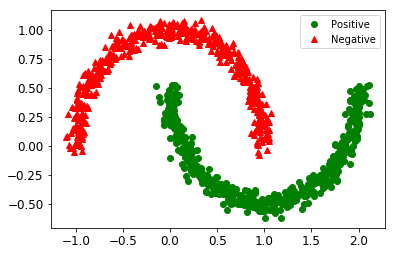

In [2]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [3]:
X_moons_wb = np.c_[np.ones((m,1)), X_moons]
y_moons_vertical = y_moons.reshape(-1, 1)

In [4]:
train_size = int(m * 0.8)
X_train = X_moons_wb[:train_size]
X_test = X_moons_wb[train_size:]
y_train = y_moons_vertical[:train_size]
y_test = y_moons_vertical[train_size:]

# Since this is a non-linear dataset going into a linear model, 
# I am going to make 4 more features of the squared and cubed
# features.
X_train_better = np.c_[
    X_train,
    X_train[:, 1] ** 2,
    X_train[:, 2] ** 2,
    X_train[:, 1] ** 3,
    X_train[:, 2] ** 3,
]
X_test_better = np.c_[
    X_test,
    X_test[:, 1] ** 2,
    X_test[:, 2] ** 2,
    X_test[:, 1] ** 3,
    X_test[:, 2] ** 3,
]

In [5]:
def batch(X, y, size):
    idxs = np.random.randint(0, len(X), size)
    return X[idxs], y[idxs]

In [6]:
def logistic_regression(X, y, l_rate=0.01):
    with tf.name_scope("lr"):
        with tf.name_scope("model"):
            # moons have 2 inputs + a bias
            theta = tf.Variable(tf.random_uniform(
                [int(X.get_shape()[1]), 1], -1, 1), name="theta")
            pre_soft = tf.matmul(X, theta, name="presoft")
            y_probs = tf.sigmoid(pre_soft)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_probs, scope="loss")
            opt = tf.train.GradientDescentOptimizer(learning_rate=l_rate)
            training_op = opt.minimize(loss)
            loss_sum = tf.summary.scalar("log_loss", loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return training_op, y_probs, loss, loss_sum, init, saver

In [7]:
X = tf.placeholder(tf.float32, shape=(None, 7), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
name = "run-" + now
logdir = "{}/{}/".format(root_logdir, name)

train, prob, loss, loss_sum, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [8]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

In [9]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = batch(X_train_better, y_train, batch_size)
            sess.run(train, feed_dict={X: X_batch, y: y_batch})
        loss_val, sum_str = sess.run([loss, loss_sum], feed_dict={X: X_test_better, y: y_test})
        file_writer.add_summary(sum_str, epoch)
        if epoch % 500 == 0:
            saver.save(sess, checkpoint_path)
            print("Epoch:", epoch, "\tLoss:", loss_val)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    os.remove(checkpoint_epoch_path)    
    prob_val = prob.eval(feed_dict={X: X_test_better, y: y_test})

('Epoch:', 0, '\tLoss:', 0.56027991)
('Epoch:', 500, '\tLoss:', 0.16248253)
('Epoch:', 1000, '\tLoss:', 0.11130361)
('Epoch:', 1500, '\tLoss:', 0.086002998)
('Epoch:', 2000, '\tLoss:', 0.070936725)
('Epoch:', 2500, '\tLoss:', 0.060850296)
('Epoch:', 3000, '\tLoss:', 0.053546809)
('Epoch:', 3500, '\tLoss:', 0.048006259)
('Epoch:', 4000, '\tLoss:', 0.043668367)
('Epoch:', 4500, '\tLoss:', 0.040135413)
('Epoch:', 5000, '\tLoss:', 0.037254285)
('Epoch:', 5500, '\tLoss:', 0.034807555)
('Epoch:', 6000, '\tLoss:', 0.032727353)
('Epoch:', 6500, '\tLoss:', 0.030929158)
('Epoch:', 7000, '\tLoss:', 0.029341653)
('Epoch:', 7500, '\tLoss:', 0.027961049)
('Epoch:', 8000, '\tLoss:', 0.026713584)
('Epoch:', 8500, '\tLoss:', 0.025589969)
('Epoch:', 9000, '\tLoss:', 0.024568591)
('Epoch:', 9500, '\tLoss:', 0.023663435)
('Epoch:', 10000, '\tLoss:', 0.022812309)


In [10]:
pred = (prob_val >= 0.5)
pred[:5]

array([[ True],
       [ True],
       [ True],
       [ True],
       [False]], dtype=bool)

In [11]:
print precision_score(y_test, pred)
print recall_score(y_test, pred)

1.0
1.0


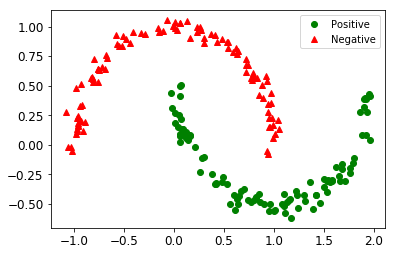

In [12]:
pred_idx = pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[pred_idx, 1], X_test[pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~pred_idx, 1], X_test[~pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()